# EVSE Charger Reliability Using Clustering
##### Author: Shammi Pereira
##### Date: April 9, 2025

### Step 1: Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

#convert scientific notation to floating point 
pd.set_option('display.float_format', '{:.3f}'.format)

### Step 2: Read data

##### Step 2.1: Create dataframes

In [2]:
#create dataframes from csv files
evse_df = pd.read_csv('data/evse.csv')
session_df = pd.read_csv('data/session.csv')
connector_df = pd.read_csv('data/connector.csv')

##### Step 2.2: EVSE dataframe

In [3]:
#display beginning of EVSE dataframe
evse_df.head()

,evse_id,metro_area,land_use,region,num_ports,charge_level,venue,pricing
0,6034,Undesignated,Metro Area,Mountain,1,DCFC,Corridor,Paid
1,6065,Undesignated,Metro Area,Mountain,1,DCFC,Corridor,Paid
2,6100,"Phoenix-Mesa-Chandler, AZ Metro Area",Metro Area,Mountain,1,DCFC,Undesignated,Free
3,6155,Undesignated,Metro Area,Mountain,1,DCFC,Corridor,Paid
4,1315,"Denver-Aurora-Lakewood, CO Metro Area",Metro Area,Mountain,1,DCFC,Corridor,Free


In [4]:
#number of EVSE chargers: 36,926
evse_df.describe()

,evse_id,num_ports
count,36926.000,36926.000
mean,19787.051,1.301
std,12012.736,0.459
min,0.000,1.000
25%,9250.250,1.000
50%,18866.500,1.000
75%,30134.500,2.000
max,41701.000,2.000


In [5]:
#count EVSEs present in each metro area
evse_df['metro_area'].value_counts()


metro_area
Undesignated                                               13621
Portland-Vancouver-Hillsboro, OR-WA Metro Area              2939
Washington-Arlington-Alexandria, DC-VA-MD-WV Metro Area     2189
Baltimore-Columbia-Towson, MD Metro Area                    1946
Detroit-Warren-Dearborn, MI Metro Area                      1843
Philadelphia-Camden-Wilmington, PA-NJ-DE-MD Metro Area      1603
New York-Newark-Jersey City, NY-NJ-PA Metro Area            1166
Burlington-South Burlington, VT Metro Area                  1163
Las Vegas-Henderson-Paradise, NV Metro Area                 1027
Boston-Cambridge-Newton, MA-NH Metro Area                    997
Kansas City, MO-KS Metro Area                                760
Providence-Warwick, RI-MA Metro Area                         750
Pittsburgh, PA Metro Area                                    695
Grand Rapids-Kentwood, MI Metro Area                         562
Seattle-Tacoma-Bellevue, WA Metro Area                       539
Albany-Schenec

In [6]:
#count EVSEs present in each region 
evse_df['region'].value_counts()

region
Middle Atlantic       6264
Pacific               6084
South Atlantic        5774
New England           4943
East North Central    4711
Mountain              3512
West South Central    2312
West North Central    1960
East South Central    1366
Name: count, dtype: int64

In [7]:
#count EVSEs present in each venue
evse_df['venue'].value_counts()

venue
Single Family Residential        17045
Business Office                   3674
Multi-Unit Dwelling               3527
Undesignated                      3298
Corridor                          1703
Fleet                             1574
Retail                            1503
Medical or Educational Campus     1270
Municipal Building                1107
Multi-use Parking Garage/Lot      1102
Leisure Destination                548
Hotel                              384
Transit Facility                   191
Name: count, dtype: int64

In [8]:
#count EVSEs with charge level of L2 or DCFC
evse_df['charge_level'].value_counts()

charge_level
L2      32099
DCFC     4827
Name: count, dtype: int64

In [9]:
#count EVSEs' pricing of free or paid 
evse_df['pricing'].value_counts()

pricing
Free            25825
Paid             5774
Undesignated     5327
Name: count, dtype: int64

##### Step 2.3: Connectors dataframe

In [10]:
#display beginning of connector dataframe
connector_df.head()

,connector_id,evse_id,connector_number,connector_type,power_kw
0,38494,25683,1,J1772,>8 kW
1,38358,27850,1,J1772,>8 kW
2,44144,31875,1,J1772,>8 kW
3,45088,32971,1,J1772,>8 kW
4,9643,5712,1,J1772,<8 kW


In [11]:
#number of connectors: 50,103
connector_df.describe()

,connector_id,evse_id,connector_number
count,50103.000,50103.000,50103.000
mean,27145.612,18616.009,1.262
std,16151.221,11972.290,0.440
min,0.000,0.000,1.000
25%,12569.500,7954.500,1.000
50%,27376.000,17472.000,1.000
75%,41447.500,28626.500,2.000
max,56139.000,41701.000,2.000


##### Step 2.4: Sessions dataframe

In [12]:
#display beginning of session dataframe
session_df.head()

,session_id,evse_id,connector_id,start_datetime,end_datetime,total_duration,charge_duration,energy_kwh,start_soc,end_soc,flag_id
0,11562,5,5,2020-03-01 09:37:44,2020-03-01 11:14:59,1.621,1.616,6.170,NaN,NaN,0
1,11563,116,116,2020-03-01 10:02:24,2020-03-01 11:08:14,1.097,1.090,5.212,NaN,NaN,0
2,11564,72,72,2020-03-01 10:06:08,2020-03-01 11:08:10,1.034,1.025,3.392,NaN,NaN,0
3,11565,1,1,2020-03-01 10:01:12,2020-03-01 11:07:09,1.100,1.076,6.521,NaN,NaN,0
4,11566,0,138,2020-02-29 19:09:03,2020-03-01 10:47:16,15.637,12.659,80.527,NaN,NaN,0


In [13]:
#number of sessions: 13,937,235
session_df.describe()

,session_id,evse_id,connector_id,total_duration,charge_duration,energy_kwh,start_soc,end_soc,flag_id
count,13937235.000,13937235.000,13937235.000,13937148.000,13937232.000,13890306.000,2588397.000,2602374.000,13937235.000
mean,7479208.739,12841.408,19051.111,7.272,1.854,17.023,40.282,77.633,36.568
std,4282421.083,9737.823,13428.731,15.744,630.181,21.651,23.655,22.944,488.046
min,1.000,0.000,0.000,0.000,-628758.329,-35.475,0.000,0.000,0.000
25%,3558841.500,4671.000,7907.000,0.938,0.696,5.120,22.000,68.000,0.000
50%,7649957.000,11191.000,15925.000,3.206,1.703,10.886,37.000,84.000,0.000
75%,11196799.500,18394.000,28470.000,9.489,3.351,22.728,56.000,96.000,0.000
max,14837317.000,42094.000,55534.000,1594.946,1589.946,936.206,100.000,100.000,66560.000


### Step 3: Data Cleaning

##### Step 3.1: Standardize format

In [14]:
#convert to datetime objects
session_df['start_datetime'] = pd.to_datetime(session_df['start_datetime'])
session_df['end_datetime'] = pd.to_datetime(session_df['end_datetime'])

##### Step 3.2: Remove missing/NaN values

In [15]:
#determine missing/NaN values in dataset
print("Missing/NaN values in EVSE dataframe:\n", evse_df.isnull().sum())
print("Missing/NaN values in connector dataframe:\n", connector_df.isnull().sum())
print("Missing/NaN values in session dataframe:\n", session_df.isnull().sum())

Missing/NaN values in EVSE dataframe:
 evse_id         0
metro_area      0
land_use        0
region          0
num_ports       0
charge_level    0
venue           0
pricing         0
dtype: int64
Missing/NaN values in connector dataframe:
 connector_id        0
evse_id             0
connector_number    0
connector_type      0
power_kw            0
dtype: int64
Missing/NaN values in session dataframe:
 session_id                0
evse_id                   0
connector_id              0
start_datetime            0
end_datetime             87
total_duration           87
charge_duration           3
energy_kwh            46929
start_soc          11348838
end_soc            11334861
flag_id                   0
dtype: int64


In [16]:
#remove rows with missing/NaN values
session_df = session_df.dropna(subset=['end_datetime','total_duration','charge_duration','energy_kwh'])

In [17]:
#remove columns end_datetime, total_duration, start_soc, end_soc, flag_id, connector_number
session_df = session_df.drop(columns=['end_datetime','total_duration','start_soc', 'end_soc','flag_id'])
connector_df = connector_df.drop(columns=['connector_number'])

In [18]:
#check for missing/NaN values
print("Missing/NaN values in EVSE dataframe:\n", evse_df.isnull().sum())
print("Missing/NaN values in connector dataframe:\n", connector_df.isnull().sum())
print("Missing/NaN values in session dataframe:\n", session_df.isnull().sum())

Missing/NaN values in EVSE dataframe:
 evse_id         0
metro_area      0
land_use        0
region          0
num_ports       0
charge_level    0
venue           0
pricing         0
dtype: int64
Missing/NaN values in connector dataframe:
 connector_id      0
evse_id           0
connector_type    0
power_kw          0
dtype: int64
Missing/NaN values in session dataframe:
 session_id         0
evse_id            0
connector_id       0
start_datetime     0
charge_duration    0
energy_kwh         0
dtype: int64


In [19]:
#number of sessions remaining after removing missing/NaN values: 13,890,216
session_df.describe()

,session_id,evse_id,connector_id,start_datetime,charge_duration,energy_kwh
count,13890216.000,13890216.000,13890216.000,13890216,13890216.000,13890216.000
mean,7463177.806,12770.809,18963.241,2021-10-31 14:16:56.141412096,1.858,17.023
min,1.000,0.000,0.000,2019-06-25 14:32:34,-628758.329,-35.475
25%,3547084.750,4665.000,7886.000,2021-04-09 09:48:51.249999872,0.703,5.120
50%,7626447.500,11139.000,15833.000,2022-01-16 18:05:52.500000,1.711,10.886
75%,11187279.250,18368.000,28429.000,2022-07-29 15:07:59.500000,3.359,22.728
max,14837317.000,42094.000,55534.000,2022-12-31 23:58:58,697.116,936.206
std,4278846.143,9673.566,13360.890,NaN,631.247,21.651


##### Step 3.3: Deduplicate sessions

Group sessions that take place within 5 minutes of one another and keep only the sessions with the highest energy output. 

In [20]:
#sort evse_id, connector_id, start_datetime
session_df = session_df.sort_values(by=['evse_id', 'connector_id', 'start_datetime'])

In [21]:
#create a list that is a boolean of whether session is new group
group_new = [True] #first session is new group

In [22]:
#loop through sessions, starting from second row
for i in range(1, len(session_df)):
    curr_session = session_df.iloc[i] #current session
    prev_session = session_df.iloc[i - 1] #previous session
    
    #check if current and previous evse are same
    if curr_session['evse_id'] == prev_session['evse_id']: 
        evse_same = True
    else: 
        evse_same = False
    
    #check if current and previous connector are same
    if curr_session['connector_id'] == prev_session['connector_id']: 
        connector_same = True
    else: 
        connector_same = False
        
    #if current and previous evse and connector are same
    if (evse_same == True) and (connector_same == True): 
        #determine time difference between current and previous session 
        time_difference = curr_session['start_datetime'] - prev_session['start_datetime']
        #if time difference is greater than 5 min, 
        if time_difference > pd.Timedelta(minutes=5): 
            #the current session is part of new group 
            group_new.append(True) 
        else: 
            #the current session is part of previous group 
            group_new.append(False) 
    #if current and previous evse and connector are not the same
    else: 
        #the current session is part of new group 
        group_new.append(True) 

In [23]:
#check if all rows are accounted for 
assert len(group_new) == len(session_df), "Length of group_new and session_df doesn't match!"

In [24]:
#assign id to each new group     
session_df['group_id'] = np.cumsum(group_new)
print(session_df['group_id'])

21892              1
21715              2
21429              3
21384              4
21242              5
              ...   
13936342    13710952
13928647    13710953
13934170    13710954
13937164    13710955
13937165    13710956
Name: group_id, Length: 13890216, dtype: int64


In [25]:
#get index of each group's highest energy session
max_energy_index = session_df.groupby('group_id')['energy_kwh'].idxmax()
print(max_energy_index)

group_id
1              21892
2              21715
3              21429
4              21384
5              21242
              ...   
13710952    13936342
13710953    13928647
13710954    13934170
13710955    13937164
13710956    13937165
Name: energy_kwh, Length: 13710956, dtype: int64


In [26]:
#save to session_df only the rows with the highest energy session
session_df = session_df.loc[max_energy_index]

In [27]:
#display beginning of session dataframe
session_df.head()

,session_id,evse_id,connector_id,start_datetime,charge_duration,energy_kwh,group_id
21892,29666,0,0,2019-10-01 15:37:16,1.409,2.740,1
21715,29564,0,0,2019-10-02 15:33:31,1.430,2.819,2
21429,29428,0,0,2019-10-03 12:55:06,0.727,2.264,3
21384,29383,0,0,2019-10-03 17:31:42,4.202,28.654,4
21242,29316,0,0,2019-10-04 10:38:15,4.559,31.894,5


In [28]:
#number of sessions: 13,710,956
session_df.describe()

,session_id,evse_id,connector_id,start_datetime,charge_duration,energy_kwh,group_id
count,13710956.000,13710956.000,13710956.000,13710956,13710956.000,13710956.000,13710956.000
mean,7448131.858,12747.229,18937.073,2021-10-30 22:34:49.260531968,1.879,17.229,6855478.500
min,1.000,0.000,0.000,2019-06-25 14:32:34,-628758.329,-35.475,1.000
25%,3533421.750,4667.000,7896.000,2021-04-08 14:30:28.249999872,0.731,5.299,3427739.750
50%,7608694.500,11092.000,15811.000,2022-01-15 21:37:48.500000,1.740,11.065,6855478.500
75%,11175963.250,18345.000,28402.000,2022-07-28 21:00:00,3.389,22.964,10283217.250
max,14837317.000,42094.000,55534.000,2022-12-31 23:58:58,697.116,936.206,13710956.000
std,4273761.604,9636.390,13317.756,NaN,635.360,21.707,3958012.213


### Step 4: Data integration

##### Step 4.1: Merge EVSE and Connectors dataframes

In [29]:
#merge EVSE and connectors dataframes
evse_connector_df = pd.merge(
    evse_df, 
    connector_df[['evse_id', 'connector_id', 'power_kw']], 
    on='evse_id',
    how='left'
)

In [30]:
#display beginning of evse_connector_df
evse_connector_df.head()

,evse_id,metro_area,land_use,region,num_ports,charge_level,venue,pricing,connector_id,power_kw
0,6034,Undesignated,Metro Area,Mountain,1,DCFC,Corridor,Paid,10272.000,30 kW - 100 kW
1,6034,Undesignated,Metro Area,Mountain,1,DCFC,Corridor,Paid,10365.000,30 kW - 100 kW
2,6065,Undesignated,Metro Area,Mountain,1,DCFC,Corridor,Paid,10312.000,30 kW - 100 kW
3,6065,Undesignated,Metro Area,Mountain,1,DCFC,Corridor,Paid,10428.000,30 kW - 100 kW
4,6100,"Phoenix-Mesa-Chandler, AZ Metro Area",Metro Area,Mountain,1,DCFC,Undesignated,Free,10367.000,<30 kW


In [31]:
#display count
evse_connector_df.describe()

,evse_id,num_ports,connector_id
count,50105.000,50105.000,50103.000
mean,18616.624,1.437,27145.612
std,11972.447,0.496,16151.221
min,0.000,1.000,0.000
25%,7955.000,1.000,12569.500
50%,17473.000,1.000,27376.000
75%,28628.000,2.000,41447.500
max,41701.000,2.000,56139.000


In [32]:
#determine missing/NaN values in evse_connector_df 
print("Missing/NaN values in evse_connector_df:\n", evse_connector_df.isnull().sum())

Missing/NaN values in evse_connector_df:
 evse_id         0
metro_area      0
land_use        0
region          0
num_ports       0
charge_level    0
venue           0
pricing         0
connector_id    2
power_kw        2
dtype: int64


##### Step 4.2: Merge EVSE and Connectors and Sessions dataframes

In [33]:
#merge evse_connector_df and session dataframes
merged_df = pd.merge(
    session_df, 
    evse_connector_df, 
    on=['evse_id', 'connector_id'], 
    how='left'
)

In [34]:
#display beginning of merged_df
merged_df.head()

,session_id,evse_id,connector_id,start_datetime,charge_duration,energy_kwh,group_id,metro_area,land_use,region,num_ports,charge_level,venue,pricing,power_kw
0,29666,0,0,2019-10-01 15:37:16,1.409,2.740,1,"Albany-Schenectady-Troy, NY Metro Area",Metro Area,Middle Atlantic,2.000,L2,Municipal Building,Undesignated,<8 kW
1,29564,0,0,2019-10-02 15:33:31,1.430,2.819,2,"Albany-Schenectady-Troy, NY Metro Area",Metro Area,Middle Atlantic,2.000,L2,Municipal Building,Undesignated,<8 kW
2,29428,0,0,2019-10-03 12:55:06,0.727,2.264,3,"Albany-Schenectady-Troy, NY Metro Area",Metro Area,Middle Atlantic,2.000,L2,Municipal Building,Undesignated,<8 kW
3,29383,0,0,2019-10-03 17:31:42,4.202,28.654,4,"Albany-Schenectady-Troy, NY Metro Area",Metro Area,Middle Atlantic,2.000,L2,Municipal Building,Undesignated,<8 kW
4,29316,0,0,2019-10-04 10:38:15,4.559,31.894,5,"Albany-Schenectady-Troy, NY Metro Area",Metro Area,Middle Atlantic,2.000,L2,Municipal Building,Undesignated,<8 kW


In [35]:
#number of sessions: 13,710,956
merged_df.describe()

,session_id,evse_id,connector_id,start_datetime,charge_duration,energy_kwh,group_id,num_ports
count,13710956.000,13710956.000,13710956.000,13710956,13710956.000,13710956.000,13710956.000,13344490.000
mean,7448131.858,12747.229,18937.073,2021-10-30 22:34:49.260531968,1.879,17.229,6855478.500,1.442
min,1.000,0.000,0.000,2019-06-25 14:32:34,-628758.329,-35.475,1.000,1.000
25%,3533421.750,4667.000,7896.000,2021-04-08 14:30:28.249999872,0.731,5.299,3427739.750,1.000
50%,7608694.500,11092.000,15811.000,2022-01-15 21:37:48.500000,1.740,11.065,6855478.500,1.000
75%,11175963.250,18345.000,28402.000,2022-07-28 21:00:00,3.389,22.964,10283217.250,2.000
max,14837317.000,42094.000,55534.000,2022-12-31 23:58:58,697.116,936.206,13710956.000,2.000
std,4273761.604,9636.390,13317.756,NaN,635.360,21.707,3958012.213,0.497


##### Step 4.3: Remove missing/NaN values

In [36]:
#determine missing/NaN values in merged_df 
print("Missing/NaN values in merged_df:\n", merged_df.isnull().sum())

Missing/NaN values in merged_df:
 session_id              0
evse_id                 0
connector_id            0
start_datetime          0
charge_duration         0
energy_kwh              0
group_id                0
metro_area         366466
land_use           366466
region             366466
num_ports          366466
charge_level       366466
venue              366466
pricing            366466
power_kw           366466
dtype: int64


In [37]:
#remove rows with missing/NaN values from merged_df
merged_df = merged_df.dropna(subset=['metro_area','land_use','region','num_ports','charge_level','venue','pricing','power_kw'])

In [38]:
#check for missing/NaN values in merged_df
print("Missing/NaN values in merged_df:\n", merged_df.isnull().sum())

Missing/NaN values in merged_df:
 session_id         0
evse_id            0
connector_id       0
start_datetime     0
charge_duration    0
energy_kwh         0
group_id           0
metro_area         0
land_use           0
region             0
num_ports          0
charge_level       0
venue              0
pricing            0
power_kw           0
dtype: int64


In [39]:
#number of sessions: 13,344,490
merged_df.describe()

,session_id,evse_id,connector_id,start_datetime,charge_duration,energy_kwh,group_id,num_ports
count,13344490.000,13344490.000,13344490.000,13344490,13344490.000,13344490.000,13344490.000,13344490.000
mean,7345511.915,12249.557,18305.416,2021-10-29 22:36:39.272652544,1.848,17.185,6696250.271,1.442
min,1.000,0.000,0.000,2019-06-25 14:32:34,-628758.329,0.000,1.000,1.000
25%,3447371.250,4574.000,7676.000,2021-04-08 08:32:47.249999872,0.742,5.277,3337653.250,1.000
50%,7468885.500,10379.000,14922.000,2022-01-14 00:20:46.500000,1.752,11.006,6673775.500,1.000
75%,11118925.750,18207.000,28134.000,2022-07-26 23:00:00,3.386,22.849,10020092.750,2.000
max,14837147.000,41701.000,54775.000,2022-12-31 23:58:58,697.116,936.206,13643122.000,2.000
std,4257171.216,9215.030,12865.047,NaN,644.023,21.757,3886168.586,0.497


### Step 5: Data Transformation: Create Reliability Index

##### Step 5.1: Calculate average power

In [40]:
#calculate a session's average power by dividing energy (kwh) by charge duration (hours)
merged_df['average_power'] = merged_df['energy_kwh'] / merged_df['charge_duration'] 
merged_df.head()

,session_id,evse_id,connector_id,start_datetime,charge_duration,energy_kwh,group_id,metro_area,land_use,region,num_ports,charge_level,venue,pricing,power_kw,average_power
0,29666,0,0,2019-10-01 15:37:16,1.409,2.740,1,"Albany-Schenectady-Troy, NY Metro Area",Metro Area,Middle Atlantic,2.000,L2,Municipal Building,Undesignated,<8 kW,1.945
1,29564,0,0,2019-10-02 15:33:31,1.430,2.819,2,"Albany-Schenectady-Troy, NY Metro Area",Metro Area,Middle Atlantic,2.000,L2,Municipal Building,Undesignated,<8 kW,1.971
2,29428,0,0,2019-10-03 12:55:06,0.727,2.264,3,"Albany-Schenectady-Troy, NY Metro Area",Metro Area,Middle Atlantic,2.000,L2,Municipal Building,Undesignated,<8 kW,3.114
3,29383,0,0,2019-10-03 17:31:42,4.202,28.654,4,"Albany-Schenectady-Troy, NY Metro Area",Metro Area,Middle Atlantic,2.000,L2,Municipal Building,Undesignated,<8 kW,6.820
4,29316,0,0,2019-10-04 10:38:15,4.559,31.894,5,"Albany-Schenectady-Troy, NY Metro Area",Metro Area,Middle Atlantic,2.000,L2,Municipal Building,Undesignated,<8 kW,6.995


##### Step 5.2: Convert power_kw from string to numerical value

In [41]:
#power_kw is the rate at which electricity is transferred (kW)
#power_kw is a string, which will be converted to numerical value

#determine conditions
conditions = [
    merged_df['power_kw'] == "<8 kW",
    merged_df['power_kw'] == ">8 kW",
    merged_df['power_kw'] == "<30 kW",
    merged_df['power_kw'] == "30 kW - 100 kW",
    merged_df['power_kw'] == ">100 kW"
]

#determine power values that correspond to conditions 
#power values are lower values to midpoint between range and divided by num_ports  
choices = [
    8 / merged_df['num_ports'], #<8 kW = 8
    8 / merged_df['num_ports'], #>8 kW = 8
    15 / merged_df['num_ports'], #<30 kW = 15
    50 / merged_df['num_ports'], #30 kW - 100 kW = 50
    100 / merged_df['num_ports'] #>100 kW = 100
]

#calculate power
merged_df['power'] = np.select(conditions, choices, default=np.nan)

In [42]:
#display count of each condition
merged_df['power_kw'].value_counts()

power_kw
<8 kW             7898980
>8 kW             2800803
30 kW - 100 kW    2337967
<30 kW             263296
Undesignated        23626
>100 kW             19818
Name: count, dtype: int64

In [43]:
#remove power_kw with Undesignated value
merged_df = merged_df[merged_df['power_kw'] != 'Undesignated']

In [44]:
#display count of each condition
merged_df['power_kw'].value_counts()

power_kw
<8 kW             7898980
>8 kW             2800803
30 kW - 100 kW    2337967
<30 kW             263296
>100 kW             19818
Name: count, dtype: int64

##### Step 5.3: Throttle threshold

Throttle threshold is the minimum expected power a charging session should deliver to not be considered throttled.

In [45]:
#calculate throttle threshold
merged_df['throttle_threshold'] = np.where(
    merged_df['num_ports'] == 1, 
    0.7 * merged_df['power'], #70% of power for EVSE with one port 
    0.7 * 0.5 * merged_df['power'] #70% of 50% of power for EVSE with two ports 
    #0.5 * merged_df['power'] #50% of power for EVSE with two ports
)
merged_df.head()

,session_id,evse_id,connector_id,start_datetime,charge_duration,energy_kwh,group_id,metro_area,land_use,region,num_ports,charge_level,venue,pricing,power_kw,average_power,power,throttle_threshold
0,29666,0,0,2019-10-01 15:37:16,1.409,2.740,1,"Albany-Schenectady-Troy, NY Metro Area",Metro Area,Middle Atlantic,2.000,L2,Municipal Building,Undesignated,<8 kW,1.945,4.000,1.400
1,29564,0,0,2019-10-02 15:33:31,1.430,2.819,2,"Albany-Schenectady-Troy, NY Metro Area",Metro Area,Middle Atlantic,2.000,L2,Municipal Building,Undesignated,<8 kW,1.971,4.000,1.400
2,29428,0,0,2019-10-03 12:55:06,0.727,2.264,3,"Albany-Schenectady-Troy, NY Metro Area",Metro Area,Middle Atlantic,2.000,L2,Municipal Building,Undesignated,<8 kW,3.114,4.000,1.400
3,29383,0,0,2019-10-03 17:31:42,4.202,28.654,4,"Albany-Schenectady-Troy, NY Metro Area",Metro Area,Middle Atlantic,2.000,L2,Municipal Building,Undesignated,<8 kW,6.820,4.000,1.400
4,29316,0,0,2019-10-04 10:38:15,4.559,31.894,5,"Albany-Schenectady-Troy, NY Metro Area",Metro Area,Middle Atlantic,2.000,L2,Municipal Building,Undesignated,<8 kW,6.995,4.000,1.400


##### Step 5.4: Determine throttled charging sessions

In [46]:
#determine throttled charging where energy >= 0.3 kWh (because this is considered point failure)
#and average power < throttle threshold, resulting in True 
merged_df['throttled'] = (
    (merged_df['energy_kwh'] >= 0.3) & 
    (merged_df['average_power'] < merged_df['throttle_threshold'])
)
merged_df.head()

,session_id,evse_id,connector_id,start_datetime,charge_duration,energy_kwh,group_id,metro_area,land_use,region,num_ports,charge_level,venue,pricing,power_kw,average_power,power,throttle_threshold,throttled
0,29666,0,0,2019-10-01 15:37:16,1.409,2.740,1,"Albany-Schenectady-Troy, NY Metro Area",Metro Area,Middle Atlantic,2.000,L2,Municipal Building,Undesignated,<8 kW,1.945,4.000,1.400,False
1,29564,0,0,2019-10-02 15:33:31,1.430,2.819,2,"Albany-Schenectady-Troy, NY Metro Area",Metro Area,Middle Atlantic,2.000,L2,Municipal Building,Undesignated,<8 kW,1.971,4.000,1.400,False
2,29428,0,0,2019-10-03 12:55:06,0.727,2.264,3,"Albany-Schenectady-Troy, NY Metro Area",Metro Area,Middle Atlantic,2.000,L2,Municipal Building,Undesignated,<8 kW,3.114,4.000,1.400,False
3,29383,0,0,2019-10-03 17:31:42,4.202,28.654,4,"Albany-Schenectady-Troy, NY Metro Area",Metro Area,Middle Atlantic,2.000,L2,Municipal Building,Undesignated,<8 kW,6.820,4.000,1.400,False
4,29316,0,0,2019-10-04 10:38:15,4.559,31.894,5,"Albany-Schenectady-Troy, NY Metro Area",Metro Area,Middle Atlantic,2.000,L2,Municipal Building,Undesignated,<8 kW,6.995,4.000,1.400,False


In [47]:
#display count of throttled conditions
merged_df['throttled'].value_counts()

throttled
False    9596732
True     3724132
Name: count, dtype: int64

##### Step 5.5: Determine point failure sessions

In [48]:
#determine point failure where energy < 0.3 kWh
merged_df['point_failure'] = merged_df['energy_kwh'] < 0.3
merged_df.head()

,session_id,evse_id,connector_id,start_datetime,charge_duration,energy_kwh,group_id,metro_area,land_use,region,num_ports,charge_level,venue,pricing,power_kw,average_power,power,throttle_threshold,throttled,point_failure
0,29666,0,0,2019-10-01 15:37:16,1.409,2.740,1,"Albany-Schenectady-Troy, NY Metro Area",Metro Area,Middle Atlantic,2.000,L2,Municipal Building,Undesignated,<8 kW,1.945,4.000,1.400,False,False
1,29564,0,0,2019-10-02 15:33:31,1.430,2.819,2,"Albany-Schenectady-Troy, NY Metro Area",Metro Area,Middle Atlantic,2.000,L2,Municipal Building,Undesignated,<8 kW,1.971,4.000,1.400,False,False
2,29428,0,0,2019-10-03 12:55:06,0.727,2.264,3,"Albany-Schenectady-Troy, NY Metro Area",Metro Area,Middle Atlantic,2.000,L2,Municipal Building,Undesignated,<8 kW,3.114,4.000,1.400,False,False
3,29383,0,0,2019-10-03 17:31:42,4.202,28.654,4,"Albany-Schenectady-Troy, NY Metro Area",Metro Area,Middle Atlantic,2.000,L2,Municipal Building,Undesignated,<8 kW,6.820,4.000,1.400,False,False
4,29316,0,0,2019-10-04 10:38:15,4.559,31.894,5,"Albany-Schenectady-Troy, NY Metro Area",Metro Area,Middle Atlantic,2.000,L2,Municipal Building,Undesignated,<8 kW,6.995,4.000,1.400,False,False


In [49]:
#display count of point failures
merged_df['point_failure'].value_counts()

point_failure
False    12913335
True       407529
Name: count, dtype: int64

##### Step 5.6: Group by EVSEs

In [50]:
#create a new table that groups sessions data based on EVSEs
reliability_by_evse = merged_df.groupby('evse_id').agg(
    total_sessions=('session_id', 'count'), #total number of sessions per EVSE
    throttled_charges=('throttled', 'sum'), #total number of throttled sessions (True) per EVSE
    point_failures=('point_failure', 'sum') #total number of point failures (True) per EVSE
)
reliability_by_evse.head()

,total_sessions,throttled_charges,point_failures
evse_id,,,
0,3620,6,109
1,4460,6,530
2,2867,4,208
3,2062,12,220
4,686,0,108


In [51]:
#number of EVSEs: 36,854
reliability_by_evse.describe()

,total_sessions,throttled_charges,point_failures
count,36854.000,36854.000,36854.000
mean,361.450,101.051,11.058
std,599.755,283.784,40.491
min,1.000,0.000,0.000
25%,47.000,0.000,0.000
50%,157.000,6.000,2.000
75%,420.000,69.000,8.000
max,9975.000,8319.000,4508.000


##### Step 5.7 : Remove EVSEs with less than 30 Charging Sessions

In [52]:
#remove EVSEs with less than 30 charging session
reliability_by_evse = reliability_by_evse[reliability_by_evse['total_sessions'] >= 30].copy()

In [53]:
#number of EVSEs: 30,079
reliability_by_evse.describe()

,total_sessions,throttled_charges,point_failures
count,30079.000,30079.000,30079.000
mean,440.131,123.183,13.383
std,637.993,309.842,44.484
min,30.000,0.000,0.000
25%,97.000,1.000,1.000
50%,225.000,13.000,4.000
75%,516.000,106.000,11.000
max,9975.000,8319.000,4508.000


##### Step 5.8: Probabilities of No Throttles and No Point Failures Sessions

In [54]:
#calculate probability of sessions with no throttles
reliability_by_evse['prob_no_throttle'] = 1 - (reliability_by_evse['throttled_charges'] / reliability_by_evse['total_sessions'])

#calculate probability of sessions with no point failures
reliability_by_evse['prob_no_point_failure'] = 1 - (reliability_by_evse['point_failures'] / reliability_by_evse['total_sessions'])
reliability_by_evse.head()

,total_sessions,throttled_charges,point_failures,prob_no_throttle,prob_no_point_failure
evse_id,,,,,
0,3620,6,109,0.998,0.970
1,4460,6,530,0.999,0.881
2,2867,4,208,0.999,0.927
3,2062,12,220,0.994,0.893
4,686,0,108,1.000,0.843


##### Step 5.9: Calculate Reliability Index

In [55]:
#calculate reliability index by multipling probabilities of no throttled sessions and no point failures  
reliability_by_evse['reliability_index'] = ( 
    reliability_by_evse['prob_no_throttle'] * reliability_by_evse['prob_no_point_failure']
)
reliability_by_evse.head()

,total_sessions,throttled_charges,point_failures,prob_no_throttle,prob_no_point_failure,reliability_index
evse_id,,,,,,
0,3620,6,109,0.998,0.970,0.968
1,4460,6,530,0.999,0.881,0.880
2,2867,4,208,0.999,0.927,0.926
3,2062,12,220,0.994,0.893,0.888
4,686,0,108,1.000,0.843,0.843


##### Step 5.10: Histogram of EVSE Reliability Index

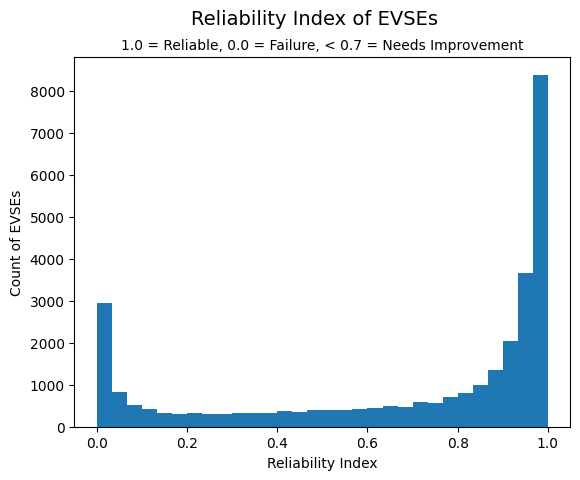

In [56]:
#create histogram of reliability index of EVSEs
plt.hist(reliability_by_evse['reliability_index'], bins=30)
plt.suptitle("Reliability Index of EVSEs", fontsize=14)
plt.title("1.0 = Reliable, 0.0 = Failure, < 0.7 = Needs Improvement", fontsize=10)
plt.xlabel("Reliability Index")
plt.ylabel("Count of EVSEs")
plt.show()

### Step 6: K-Means Clustering Using Reliability Index

##### Step 6.1: Create 2D Numpy Array

In [57]:
#create a 2D numpy array of reliability index
X = reliability_by_evse[['reliability_index']].values 
X

array([[0.96828195],
       [0.87998049],
       [0.92615633],
       ...,
       [0.85294118],
       [0.98047759],
       [0.99242424]], shape=(30079, 1))

##### Step 6.2: Standardize Data

In [58]:
#standardize to have mean = 0 and standard deviation = 1 
#fit calculates mean and standard deviation
#transform standardizes using X_scaled = (X - mean) / standard deviation
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled

array([[0.79661356],
       [0.54735818],
       [0.6777023 ],
       ...,
       [0.4710322 ],
       [0.83103915],
       [0.86476188]], shape=(30079, 1))

##### Step 6.3: Apply Elbow Method

In [59]:
#store inertia values for each cluster_count
inertia = []

#range of cluster counts 
cluster_counts = range(1, 10)

#loop through each cluster count 
for cluster_count in cluster_counts:
    #create and fit a kmeans model with each cluster count 
    kmeans = KMeans(n_clusters=cluster_count, random_state=42).fit(X_scaled)
    #append inertia (sum of squared distances to cluster centers)
    inertia.append(kmeans.inertia_)

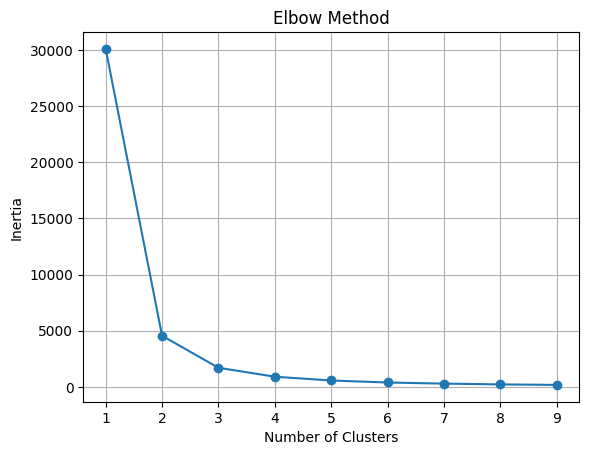

In [60]:
#plot elbow method to determine ideal number of clusters 
plt.plot(cluster_counts, inertia, marker='o')
plt.title("Elbow Method")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.grid(True)
plt.show()

##### Step 6.4: Apply K-Means

In [61]:
#apply k-means clustering method using cluster count of 3 from elbow method 
kmeans = KMeans(n_clusters=3, random_state=42).fit(X_scaled) #train model using fit
print("Cluster centers:\n", kmeans.cluster_centers_)
print("Predicted labels:", kmeans.labels_)

Cluster centers:
 [[-1.68289546]
 [ 0.70974048]
 [-0.35965598]]
Predicted labels: [1 1 1 ... 1 1 1]


##### Step 6.5: Visualization

In [62]:
#add cluster labels to reliability_by_evse dataframe
reliability_by_evse['cluster'] = kmeans.labels_
reliability_by_evse.head()

,total_sessions,throttled_charges,point_failures,prob_no_throttle,prob_no_point_failure,reliability_index,cluster
evse_id,,,,,,,
0,3620,6,109,0.998,0.970,0.968,1
1,4460,6,530,0.999,0.881,0.880,1
2,2867,4,208,0.999,0.927,0.926,1
3,2062,12,220,0.994,0.893,0.888,1
4,686,0,108,1.000,0.843,0.843,1


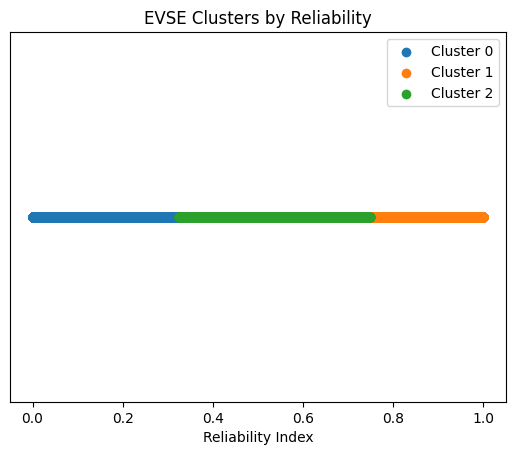

In [63]:
#plot scatterplot showing EVSE clusters of reliabilty index 
for cluster_label in range(3):
    cluster_data = reliability_by_evse[reliability_by_evse['cluster'] == cluster_label]
    plt.scatter(cluster_data['reliability_index'], [0] * len(cluster_data['reliability_index']), 
                label=f'Cluster {cluster_label}')
plt.title('EVSE Clusters by Reliability')
plt.xlabel('Reliability Index')
plt.yticks([])
plt.legend()
plt.show()

##### Step 6.6: Interpretation

In [65]:
#get mean reliability index for each cluster 
reliability_by_evse.groupby('cluster')['reliability_index'].describe()

,count,mean,std,min,25%,50%,75%,max
cluster,,,,,,,,
0,6519.000,0.089,0.096,0.000,0.012,0.043,0.152,0.324
1,18235.000,0.937,0.063,0.748,0.908,0.961,0.984,1.000
2,5325.000,0.557,0.123,0.324,0.454,0.567,0.666,0.748


- Cluster 0 has mean reliability index of 0.089, which means low reliable EVSEs. 
- Cluster 1 has mean reliability index of 0.937, which means high reliable EVSEs. 
- Cluster 2 has mean reliability index of 0.557, which means moderate reliable EVSEs. 

### Step 7: K-Means Clustering Using Reliability Index and Venue

##### Step 7.1: Create Dataframe

In [66]:
#create dataframe with evse_id, reliability_index, venue
reliability_venue_df = pd.merge(
    reliability_by_evse[['reliability_index']], 
    evse_df[['evse_id', 'venue']], 
    on='evse_id', 
    how='left'
)
reliability_venue_df.head()

,evse_id,reliability_index,venue
0,0,0.968,Municipal Building
1,1,0.880,Municipal Building
2,2,0.926,Municipal Building
3,3,0.888,Municipal Building
4,4,0.843,Municipal Building


##### Step 7.2: Encode Categorical Values

In [67]:
#encode by converting categorical format to numerical
encoded_venue = pd.get_dummies(reliability_venue_df[['reliability_index','venue']], drop_first=True)
encoded_venue.head()

,reliability_index,venue_Corridor,venue_Fleet,venue_Hotel,venue_Leisure Destination,venue_Medical or Educational Campus,venue_Multi-Unit Dwelling,venue_Multi-use Parking Garage/Lot,venue_Municipal Building,venue_Retail,venue_Single Family Residential,venue_Transit Facility,venue_Undesignated
0,0.968,False,False,False,False,False,False,False,True,False,False,False,False
1,0.880,False,False,False,False,False,False,False,True,False,False,False,False
2,0.926,False,False,False,False,False,False,False,True,False,False,False,False
3,0.888,False,False,False,False,False,False,False,True,False,False,False,False
4,0.843,False,False,False,False,False,False,False,True,False,False,False,False


##### Step 7.3: Convert Boolean to Binary Values

In [68]:
#convert boolean values to binary for computation
encoded_venue[encoded_venue.columns[1:]] = encoded_venue[encoded_venue.columns[1:]].astype(int)
encoded_venue.head()

,reliability_index,venue_Corridor,venue_Fleet,venue_Hotel,venue_Leisure Destination,venue_Medical or Educational Campus,venue_Multi-Unit Dwelling,venue_Multi-use Parking Garage/Lot,venue_Municipal Building,venue_Retail,venue_Single Family Residential,venue_Transit Facility,venue_Undesignated
0,0.968,0,0,0,0,0,0,0,1,0,0,0,0
1,0.880,0,0,0,0,0,0,0,1,0,0,0,0
2,0.926,0,0,0,0,0,0,0,1,0,0,0,0
3,0.888,0,0,0,0,0,0,0,1,0,0,0,0
4,0.843,0,0,0,0,0,0,0,1,0,0,0,0


##### Step 7.4: Standardize Data

In [69]:
#standardize to have mean = 0 and standard deviation = 1 
#fit calculates mean and standard deviation
#transform standardizes using X_scaled = (X - mean) / standard deviation
scaler = StandardScaler()
X_scaled = scaler.fit_transform(encoded_venue)
X_scaled

array([[ 0.79661356, -0.23545815, -0.20126554, ..., -0.9400558 ,
        -0.07266755, -0.28916351],
       [ 0.54735818, -0.23545815, -0.20126554, ..., -0.9400558 ,
        -0.07266755, -0.28916351],
       [ 0.6777023 , -0.23545815, -0.20126554, ..., -0.9400558 ,
        -0.07266755, -0.28916351],
       ...,
       [ 0.4710322 , -0.23545815, -0.20126554, ..., -0.9400558 ,
        -0.07266755, -0.28916351],
       [ 0.83103915, -0.23545815, -0.20126554, ..., -0.9400558 ,
        -0.07266755, -0.28916351],
       [ 0.86476188, -0.23545815, -0.20126554, ..., -0.9400558 ,
        -0.07266755, -0.28916351]], shape=(30079, 13))

##### Step 7.5: Apply Elbow Method

In [70]:
#store inertia values for each cluster_count
inertia = []

#range of cluster counts 
cluster_counts = range(1, 10)

#loop through each cluster count 
for cluster_count in cluster_counts:
    #create and fit a kmeans model with each cluster count 
    kmeans = KMeans(n_clusters=cluster_count, random_state=42).fit(X_scaled)
    #append inertia (sum of squared distances to cluster centers)
    inertia.append(kmeans.inertia_)

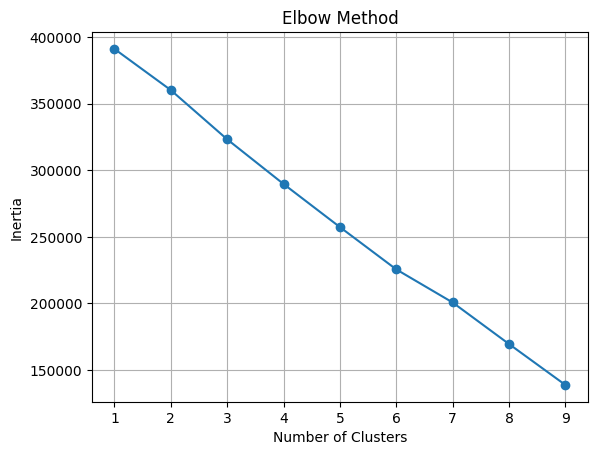

In [71]:
#plot elbow method to determine ideal number of clusters 
plt.plot(cluster_counts, inertia, marker='o')
plt.title("Elbow Method")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.grid(True)
plt.show()

##### Step 7.6: Apply K-Means

In [72]:
#apply k-means clustering method using cluster count of 3 from elbow method 
kmeans = KMeans(n_clusters=3, random_state=42).fit(X_scaled) #train model using fit
print("Cluster centers:\n", kmeans.cluster_centers_)
print("Predicted labels:", kmeans.labels_)

Cluster centers:
 [[-0.06131568 -0.23545815  0.03555589  0.01808639  0.02294528  0.03544517
  -0.32888881  0.03205943  0.03250562  0.03233464  0.16607174  0.01283756
   0.05108408]
 [ 0.65165837 -0.23545815 -0.20126554 -0.10237874 -0.12988266 -0.20063879
   3.04054124 -0.18147367 -0.1839994  -0.18303155 -0.9400558  -0.07266755
  -0.28916351]
 [-0.21889629  4.24703918 -0.20126554 -0.10237874 -0.12988266 -0.20063879
  -0.32888881 -0.18147367 -0.1839994  -0.18303155 -0.9400558  -0.07266755
  -0.28916351]]
Predicted labels: [0 0 0 ... 0 0 0]


##### Step 7.7: Visualizations

In [73]:
#combine cluster data to reliabilty_venue_df
reliability_venue_df['cluster'] = kmeans.labels_
reliability_venue_df.head()

,evse_id,reliability_index,venue,cluster
0,0,0.968,Municipal Building,0
1,1,0.880,Municipal Building,0
2,2,0.926,Municipal Building,0
3,3,0.888,Municipal Building,0
4,4,0.843,Municipal Building,0


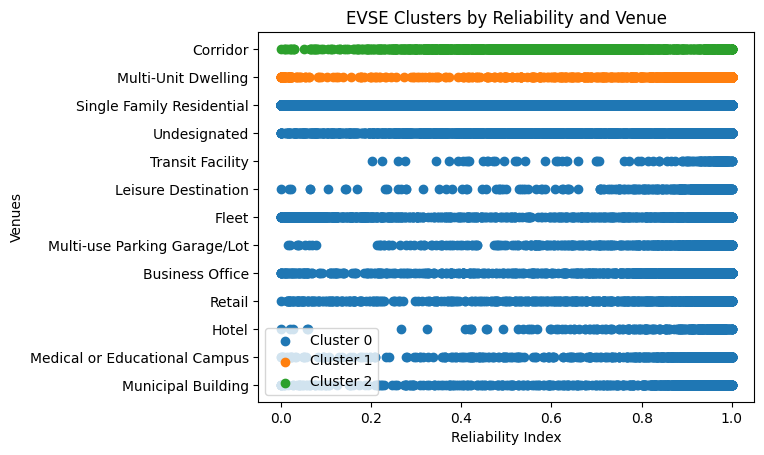

In [74]:
#plot scatterplot showing EVSE clusters of reliabilty index and venues
for cluster_label in range(3):
    cluster_data = reliability_venue_df[reliability_venue_df['cluster'] == cluster_label]
    plt.scatter(cluster_data['reliability_index'], cluster_data['venue'], 
                label=f'Cluster {cluster_label}')
plt.title('EVSE Clusters by Reliability and Venue')
plt.xlabel('Reliability Index')
plt.ylabel('Venues')
plt.legend()
plt.show()

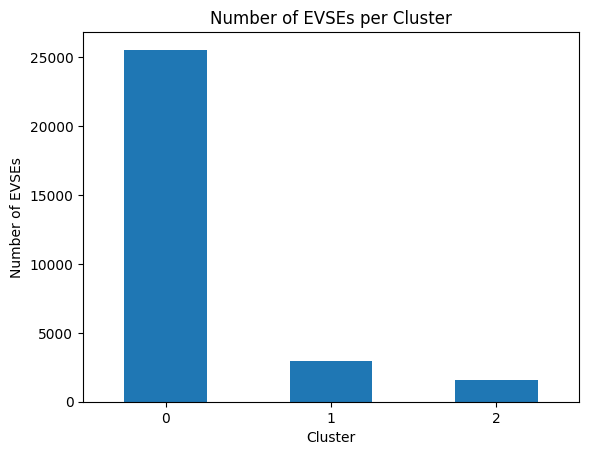

In [75]:
#plot bar graph showing count of EVSEs in each cluster
reliability_venue_df['cluster'].value_counts().sort_index().plot.bar()
plt.title('Number of EVSEs per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Number of EVSEs')
plt.xticks(rotation=0)
plt.show()

In [76]:
#display cluster of each venue 
venue_cluster_count = pd.crosstab(reliability_venue_df['venue'], reliability_venue_df['cluster'])
venue_cluster_count

cluster,0,1,2
venue,,,
Business Office,2908,0,0
Corridor,0,0,1580
Fleet,1171,0,0
Hotel,312,0,0
Leisure Destination,499,0,0
Medical or Educational Campus,1164,0,0
Multi-Unit Dwelling,0,2936,0
Multi-use Parking Garage/Lot,959,0,0
Municipal Building,985,0,0


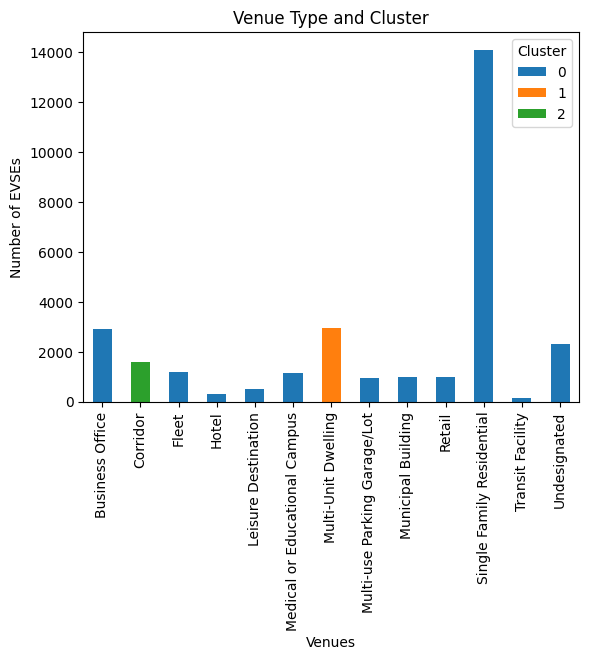

In [77]:
#plot bar group of each venue vs count of EVSEs and display cluster
venue_cluster_count.plot.bar(stacked=True)
plt.title('Venue Type and Cluster')
plt.xlabel('Venues')
plt.ylabel('Number of EVSEs')
plt.legend(title='Cluster')
plt.show()

##### Step 7.8: Interpretation

In [78]:
#get mean reliability index for each cluster
reliability_venue_df.groupby('cluster')['reliability_index'].describe()

,count,mean,std,min,25%,50%,75%,max
cluster,,,,,,,,
0,25563.000,0.664,0.366,0.000,0.340,0.863,0.966,1.000
1,2936.000,0.917,0.186,0.000,0.951,0.981,0.992,1.000
2,1580.000,0.609,0.223,0.000,0.456,0.610,0.763,1.000


- Cluster 0 has mean reliability index of 0.664, which means moderate reliable EVSEs at mostly Single Family Residential and other venues. 
- Cluster 1 has mean reliability index of 0.917, which means high reliable EVSEs at only Multi-Unit Dwelling venues. 
- Cluster 2 has mean reliability index of 0.609, which means moderate reliable EVSEs at only Corridor venues. 

### Step 8: K-Means Clustering Using Reliability Index and Charge Level

##### Step 8.1: Create Dataframe

In [79]:
#create dataframe with evse_id, reliability_index, charge level
reliability_charge_df = pd.merge(
    reliability_by_evse[['reliability_index']], 
    evse_df[['evse_id', 'charge_level']], 
    on='evse_id', 
    how='left'
)
reliability_charge_df.head()

,evse_id,reliability_index,charge_level
0,0,0.968,L2
1,1,0.880,L2
2,2,0.926,L2
3,3,0.888,L2
4,4,0.843,L2


##### Step 8.2: Encode Categorical Values

In [80]:
#encode by converting categorical format to numerical
encoded_charge = pd.get_dummies(reliability_charge_df[['reliability_index','charge_level']], drop_first=True)
encoded_charge.head()

,reliability_index,charge_level_L2
0,0.968,True
1,0.880,True
2,0.926,True
3,0.888,True
4,0.843,True


##### Step 8.3: Convert Boolean to Binary Values

In [81]:
#convert boolean values to binary for computation
encoded_charge[encoded_charge.columns[1:]] = encoded_charge[encoded_charge.columns[1:]].astype(int)
encoded_charge.head()

,reliability_index,charge_level_L2
0,0.968,1
1,0.880,1
2,0.926,1
3,0.888,1
4,0.843,1


##### Step 8.4: Standardize Data

In [82]:
#standardize to have mean = 0 and standard deviation = 1 
#fit calculates mean and standard deviation
#transform standardizes using X_scaled = (X - mean) / standard deviation
scaler = StandardScaler()
X_scaled = scaler.fit_transform(encoded_charge)
X_scaled

array([[0.79661356, 0.37808653],
       [0.54735818, 0.37808653],
       [0.6777023 , 0.37808653],
       ...,
       [0.4710322 , 0.37808653],
       [0.83103915, 0.37808653],
       [0.86476188, 0.37808653]], shape=(30079, 2))

##### Step 8.5: Apply Elbow Method

In [83]:
#store inertia values for each cluster_count
inertia = []

#range of cluster counts 
cluster_counts = range(1, 10)

#loop through each cluster count 
for cluster_count in cluster_counts:
    #create and fit a kmeans model with each cluster count 
    kmeans = KMeans(n_clusters=cluster_count, random_state=42).fit(X_scaled)
    #append inertia (sum of squared distances to cluster centers)
    inertia.append(kmeans.inertia_)

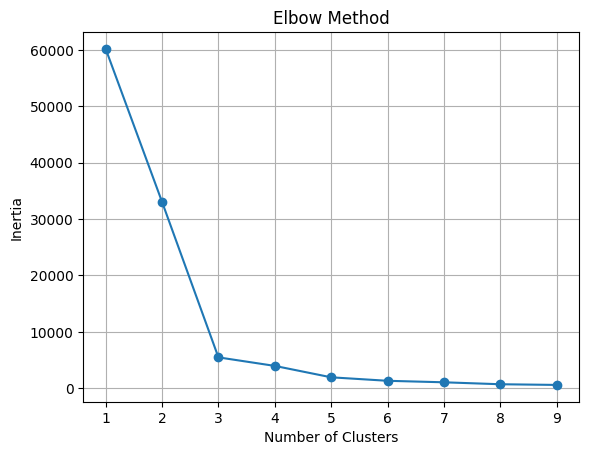

In [84]:
#plot elbow method to determine ideal number of clusters 
plt.plot(cluster_counts, inertia, marker='o')
plt.title("Elbow Method")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.grid(True)
plt.show()

##### Step 8.6: Apply K-Means

In [85]:
#apply k-means clustering method using cluster count of 3 from elbow method 
kmeans = KMeans(n_clusters=3, random_state=42).fit(X_scaled) #train model using fit
print("Cluster centers:\n", kmeans.cluster_centers_)
print("Predicted labels:", kmeans.labels_)
cluster_centers = kmeans.cluster_centers_
labels = kmeans.labels_

Cluster centers:
 [[-1.52520405  0.37808653]
 [ 0.62260461  0.37808653]
 [-0.13630504 -2.64489719]]
Predicted labels: [1 1 1 ... 1 1 1]


##### Step 8.7: Visualizations

In [86]:
#combine cluster data to reliabilty_charge_df
reliability_charge_df['cluster'] = kmeans.labels_
reliability_charge_df.head()

,evse_id,reliability_index,charge_level,cluster
0,0,0.968,L2,1
1,1,0.880,L2,1
2,2,0.926,L2,1
3,3,0.888,L2,1
4,4,0.843,L2,1


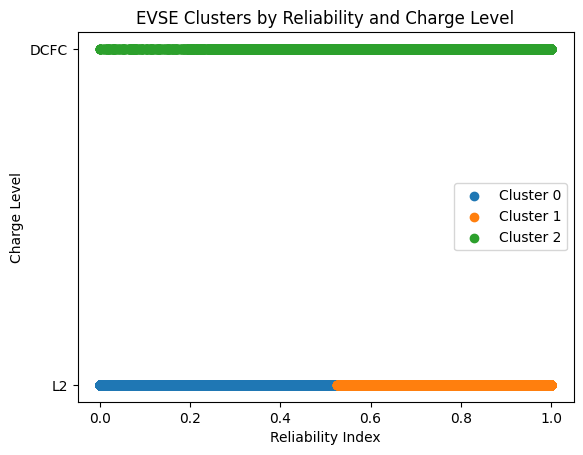

In [87]:
#plot scatterplot showing EVSE clusters of reliabilty index and charge level
for cluster_label in range(3):
    cluster_data = reliability_charge_df[reliability_charge_df['cluster'] == cluster_label]
    plt.scatter(cluster_data['reliability_index'], cluster_data['charge_level'], 
                label=f'Cluster {cluster_label}')
plt.title('EVSE Clusters by Reliability and Charge Level')
plt.xlabel('Reliability Index')
plt.ylabel('Charge Level')
plt.legend()
plt.show()

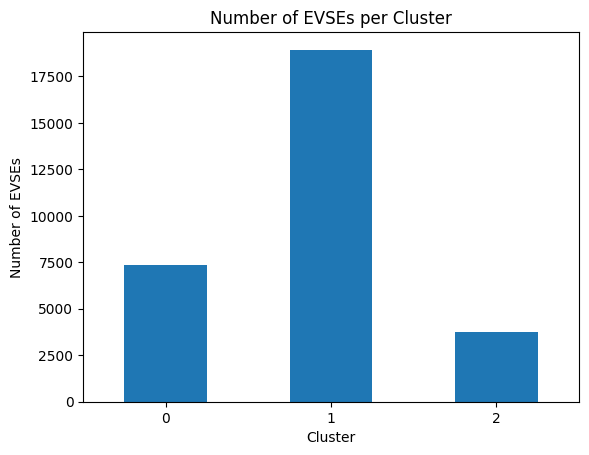

In [88]:
#plot bar graph showing count of EVSEs in each cluster
reliability_charge_df['cluster'].value_counts().sort_index().plot.bar()
plt.title('Number of EVSEs per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Number of EVSEs')
plt.xticks(rotation=0)
plt.show()

In [89]:
#display cluster of each charge level 
charge_cluster_count = pd.crosstab(reliability_charge_df['charge_level'], reliability_charge_df['cluster'])
charge_cluster_count

cluster,0,1,2
charge_level,,,
DCFC,0,0,3762
L2,7379,18938,0


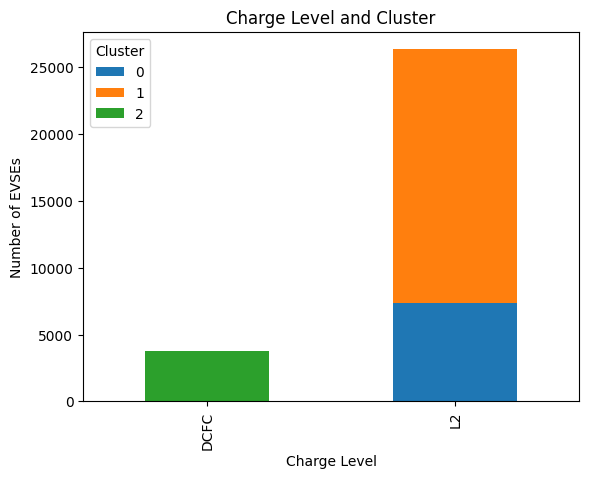

In [90]:
#plot bar group of each charge level vs count of EVSEs and display cluster
charge_cluster_count.plot.bar(stacked=True)
plt.title('Charge Level and Cluster')
plt.xlabel('Charge Level')
plt.ylabel('Number of EVSEs')
plt.legend(title='Cluster')
plt.show()

##### Step 8.8: Interpretation

In [91]:
#get mean reliability index for each cluster
reliability_charge_df.groupby('cluster')['reliability_index'].describe()

,count,mean,std,min,25%,50%,75%,max
cluster,,,,,,,,
0,7379.000,0.145,0.160,0.000,0.015,0.067,0.258,0.526
1,18938.000,0.906,0.111,0.526,0.874,0.953,0.982,1.000
2,3762.000,0.638,0.266,0.000,0.443,0.651,0.891,1.000


- Cluster 0 has mean reliability index of 0.145, which means low reliable EVSEs at only L2 charger levels. 
- Cluster 1 has mean reliability index of 0.906, which means high reliable EVSEs at only L2 charger levels. 
- Cluster 2 has mean reliability index of 0.638, which means moderate reliable EVSEs at only DCFC charger levels. 

### Step 9: K-Means Clustering Using Reliability Index, Venue, and Charge Level

##### Step 9.1: Create Dataframe

In [92]:
#create dataframe with evse_id, reliability_index, venue, charge_level
reliability_venue_charge_df = pd.merge(
    reliability_by_evse[['reliability_index']], 
    evse_df[['evse_id', 'venue', 'charge_level']], 
    on='evse_id', 
    how='left'
)
reliability_venue_charge_df.head()

,evse_id,reliability_index,venue,charge_level
0,0,0.968,Municipal Building,L2
1,1,0.880,Municipal Building,L2
2,2,0.926,Municipal Building,L2
3,3,0.888,Municipal Building,L2
4,4,0.843,Municipal Building,L2


##### Step 9.2: Encode Categorical Values

In [93]:
#encode by converting categorical format to numerical
encoded_venue = pd.get_dummies(reliability_venue_charge_df[['reliability_index','venue', 'charge_level']], drop_first=True)
encoded_venue.head()

,reliability_index,venue_Corridor,venue_Fleet,venue_Hotel,venue_Leisure Destination,venue_Medical or Educational Campus,venue_Multi-Unit Dwelling,venue_Multi-use Parking Garage/Lot,venue_Municipal Building,venue_Retail,venue_Single Family Residential,venue_Transit Facility,venue_Undesignated,charge_level_L2
0,0.968,False,False,False,False,False,False,False,True,False,False,False,False,True
1,0.880,False,False,False,False,False,False,False,True,False,False,False,False,True
2,0.926,False,False,False,False,False,False,False,True,False,False,False,False,True
3,0.888,False,False,False,False,False,False,False,True,False,False,False,False,True
4,0.843,False,False,False,False,False,False,False,True,False,False,False,False,True


##### Step 9.3: Convert Boolean to Binary Values

In [94]:
#convert boolean values to binary for computation
encoded_venue[encoded_venue.columns[1:]] = encoded_venue[encoded_venue.columns[1:]].astype(int)
encoded_venue.head()

,reliability_index,venue_Corridor,venue_Fleet,venue_Hotel,venue_Leisure Destination,venue_Medical or Educational Campus,venue_Multi-Unit Dwelling,venue_Multi-use Parking Garage/Lot,venue_Municipal Building,venue_Retail,venue_Single Family Residential,venue_Transit Facility,venue_Undesignated,charge_level_L2
0,0.968,0,0,0,0,0,0,0,1,0,0,0,0,1
1,0.880,0,0,0,0,0,0,0,1,0,0,0,0,1
2,0.926,0,0,0,0,0,0,0,1,0,0,0,0,1
3,0.888,0,0,0,0,0,0,0,1,0,0,0,0,1
4,0.843,0,0,0,0,0,0,0,1,0,0,0,0,1


##### Step 9.4: Standardize Data

In [95]:
#standardize to have mean = 0 and standard deviation = 1 
#fit calculates mean and standard deviation
#transform standardizes using X_scaled = (X - mean) / standard deviation
scaler = StandardScaler()
X_scaled = scaler.fit_transform(encoded_venue)
X_scaled

array([[ 0.79661356, -0.23545815, -0.20126554, ..., -0.07266755,
        -0.28916351,  0.37808653],
       [ 0.54735818, -0.23545815, -0.20126554, ..., -0.07266755,
        -0.28916351,  0.37808653],
       [ 0.6777023 , -0.23545815, -0.20126554, ..., -0.07266755,
        -0.28916351,  0.37808653],
       ...,
       [ 0.4710322 , -0.23545815, -0.20126554, ..., -0.07266755,
        -0.28916351,  0.37808653],
       [ 0.83103915, -0.23545815, -0.20126554, ..., -0.07266755,
        -0.28916351,  0.37808653],
       [ 0.86476188, -0.23545815, -0.20126554, ..., -0.07266755,
        -0.28916351,  0.37808653]], shape=(30079, 14))

##### Step 9.5: Apply Elbow Method

In [96]:
#store inertia values for each cluster_count
inertia = []

#range of cluster counts 
cluster_counts = range(1, 10)

#loop through each cluster count 
for cluster_count in cluster_counts:
    #create and fit a kmeans model with each cluster count 
    kmeans = KMeans(n_clusters=cluster_count, random_state=42).fit(X_scaled)
    #append inertia (sum of squared distances to cluster centers)
    inertia.append(kmeans.inertia_)

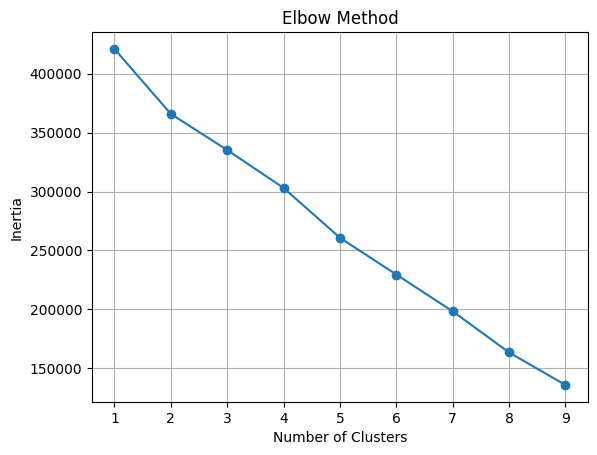

In [97]:
#plot elbow method to determine ideal number of clusters 
plt.plot(cluster_counts, inertia, marker='o')
plt.title("Elbow Method")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.grid(True)
plt.show()

##### Step 9.6: Apply K-Means

In [98]:
#apply k-means clustering method using cluster count of 3 from elbow method 
kmeans = KMeans(n_clusters=3, random_state=42).fit(X_scaled) #train model using fit
print("Cluster centers:\n", kmeans.cluster_centers_)
print("Predicted labels:", kmeans.labels_)
cluster_centers = kmeans.cluster_centers_
labels = kmeans.labels_

Cluster centers:
 [[-0.09985006 -0.23545815  1.1539765  -0.10237874 -0.12988266 -0.20063879
  -0.32888881 -0.18147367 -0.1839994   1.04943008 -0.9400558  -0.07266755
   1.65794846 -1.09855338]
 [ 0.03295133 -0.23545815 -0.20126554  0.02576083  0.03268144  0.0504853
   0.08275594  0.04566292  0.04629845 -0.18303155  0.23653951  0.01828481
  -0.28916351  0.37808653]
 [-0.21889629  4.24703918 -0.20126554 -0.10237874 -0.12988266 -0.20063879
  -0.32888881 -0.18147367 -0.1839994  -0.18303155 -0.9400558  -0.07266755
  -0.28916351 -2.64489719]]
Predicted labels: [1 1 1 ... 1 1 1]


##### Step 9.7: Visualizations

In [99]:
#combine cluster data to reliabilty_venue_charge_df
reliability_venue_charge_df['cluster'] = kmeans.labels_
reliability_venue_charge_df.head()

,evse_id,reliability_index,venue,charge_level,cluster
0,0,0.968,Municipal Building,L2,1
1,1,0.880,Municipal Building,L2,1
2,2,0.926,Municipal Building,L2,1
3,3,0.888,Municipal Building,L2,1
4,4,0.843,Municipal Building,L2,1


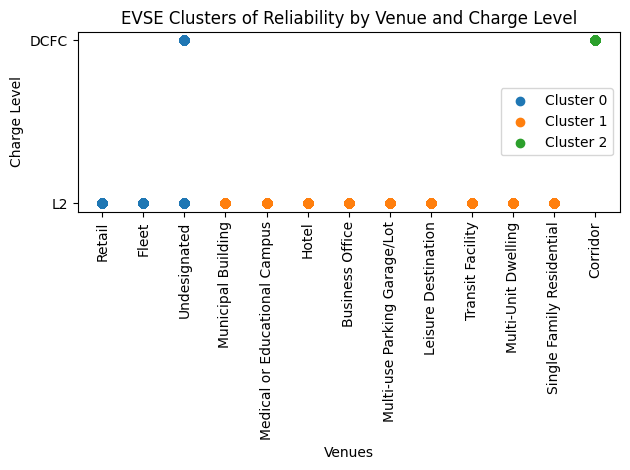

In [100]:
#plot scatterplot showing EVSE clusters of reliabilty index by venues and charger levels
for cluster_label in range(3):
    cluster_data = reliability_venue_charge_df[reliability_venue_charge_df['cluster'] == cluster_label]
    plt.scatter(cluster_data['venue'], cluster_data['charge_level'], 
                label=f'Cluster {cluster_label}')
plt.title('EVSE Clusters of Reliability by Venue and Charge Level')
plt.xlabel('Venues')
plt.ylabel('Charge Level')
plt.xticks(rotation=90)    
plt.tight_layout()     
plt.legend()
plt.show()

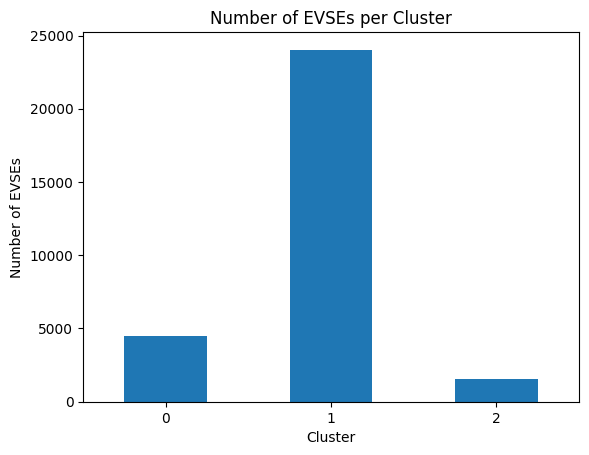

In [101]:
#plot bar graph showing count of EVSEs in each cluster
reliability_venue_charge_df['cluster'].value_counts().sort_index().plot.bar()
plt.title('Number of EVSEs per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Number of EVSEs')
plt.xticks(rotation=0)
plt.show()

In [102]:
#display cluster of each venue and charge level
venue_charge_cluster_count = pd.crosstab(
    [reliability_venue_charge_df['venue'], reliability_venue_charge_df['charge_level']],
    reliability_venue_charge_df['cluster']
)
venue_charge_cluster_count

,cluster,0,1,2
venue,charge_level,,,
Business Office,L2,0,2908,0
Corridor,DCFC,0,0,1580
Fleet,L2,1171,0,0
Hotel,L2,0,312,0
Leisure Destination,L2,0,499,0
Medical or Educational Campus,L2,0,1164,0
Multi-Unit Dwelling,L2,0,2936,0
Multi-use Parking Garage/Lot,L2,0,959,0
Municipal Building,L2,0,985,0


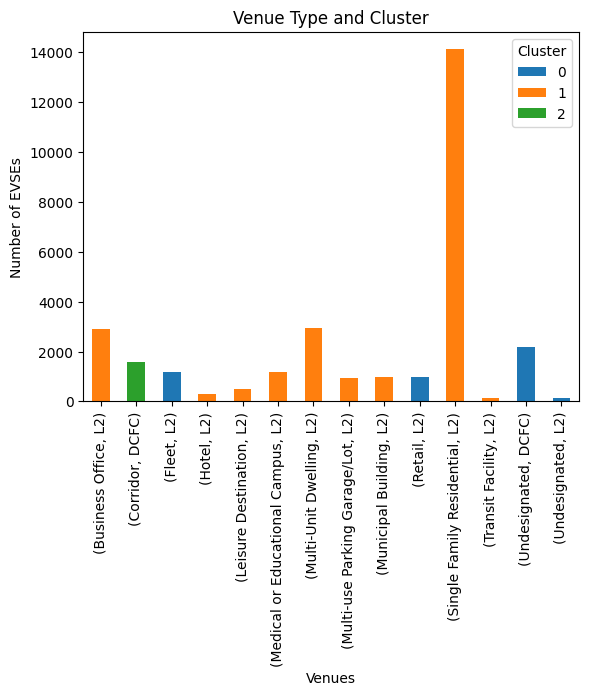

In [103]:
#plot bar group of each venue and charge level vs count of EVSEs and display cluster
venue_charge_cluster_count.plot.bar(stacked=True)
plt.title('Venue Type and Cluster')
plt.xlabel('Venues')
plt.ylabel('Number of EVSEs')
plt.legend(title='Cluster')
plt.show()

##### Step 9.8: Interpretation

In [104]:
#get mean reliability index for each cluster
reliability_venue_charge_df.groupby('cluster')['reliability_index'].describe()

,count,mean,std,min,25%,50%,75%,max
cluster,,,,,,,,
0,4467.000,0.651,0.330,0.000,0.379,0.765,0.952,1.000
1,24032.000,0.698,0.364,0.000,0.430,0.905,0.975,1.000
2,1580.000,0.609,0.223,0.000,0.456,0.610,0.763,1.000


- Cluster 0 has mean reliability index of 0.651, which means moderate reliable EVSEs at Fleets and Retails with L2 chargers and at Undesignated venues with DCFC. 
- Cluster 1 has mean reliability index of 0.698, which means high reliable EVSEs at various venues with only L2 chargers. 
- Cluster 2 has mean reliability index of 0.609, which means moderate reliable EVSEs at Corridors with L2 chargers. 